In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import os

from scipy.signal import butter, filtfilt
from scipy.ndimage import gaussian_filter1d

In [ ]:
data = pd.read_csv("../Data/raw/Take1_KeyFrames.csv")

print("data head")
print(data.head())


data head
     Time  Imani_Hips_x  Imani_Hips_y  Imani_Hips_z  Imani_LeftUpLeg_x  \
0  0.0476        5.2586        0.9584        5.9734              5.286   
1  0.0543        5.2586        0.9584        5.9734              5.286   
2  0.0600        5.2586        0.9584        5.9734              5.286   
3  0.0648        5.2586        0.9584        5.9734              5.286   
4  0.0668        5.2586        0.9584        5.9734              5.286   

   Imani_LeftUpLeg_y  Imani_LeftUpLeg_z  Imani_LeftLeg_x  Imani_LeftLeg_y  \
0              0.933             5.9066           5.3542           0.6682   
1              0.933             5.9066           5.3542           0.6682   
2              0.933             5.9066           5.3542           0.6682   
3              0.933             5.9066           5.3542           0.6682   
4              0.933             5.9066           5.3542           0.6682   

   Imani_LeftLeg_z  ...  Imani_RightHandThumb1_z  Imani_RightHandThumb2_x  \
0    

In [10]:
print("data shape")
print(data.shape)

data shape
(6132, 193)


In [11]:
print("data columns")
print(data.columns[:10])

data columns
Index(['Time', 'Imani_Hips_x', 'Imani_Hips_y', 'Imani_Hips_z',
       'Imani_LeftUpLeg_x', 'Imani_LeftUpLeg_y', 'Imani_LeftUpLeg_z',
       'Imani_LeftLeg_x', 'Imani_LeftLeg_y', 'Imani_LeftLeg_z'],
      dtype='object')


In [33]:
root  = data[['Imani_Hips_x','Imani_Hips_y','Imani_Hips_z']].to_numpy()
print("root\n", root, "\n")

joint = data[['Imani_LeftLeg_x','Imani_LeftLeg_y','Imani_LeftLeg_z']].to_numpy()
print ("joint\n", joint)


root
 [[5.2586 0.9584 5.9734]
 [5.2586 0.9584 5.9734]
 [5.2586 0.9584 5.9734]
 ...
 [5.2586 0.9584 5.9734]
 [5.2586 0.9584 5.9734]
 [5.2586 0.9584 5.9734]] 

joint
 [[5.3542 0.6682 5.9913]
 [5.3542 0.6682 5.9913]
 [5.3542 0.6682 5.9913]
 ...
 [5.3542 0.6682 5.9913]
 [5.3542 0.6682 5.9913]
 [5.3542 0.6682 5.9913]]


In [34]:
joint_relation = joint-root
print(joint_relation)

[[ 0.0956 -0.2902  0.0179]
 [ 0.0956 -0.2902  0.0179]
 [ 0.0956 -0.2902  0.0179]
 ...
 [ 0.0956 -0.2902  0.0179]
 [ 0.0956 -0.2902  0.0179]
 [ 0.0956 -0.2902  0.0179]]


In [35]:
import numpy as np

print("Min:", np.min(joint_relation[:,1]))
print("Max:", np.max(joint_relation[:,1]))
print("Std:", np.std(joint_relation[:,1]))


Min: -0.2902
Max: -0.2902
Std: 0.0


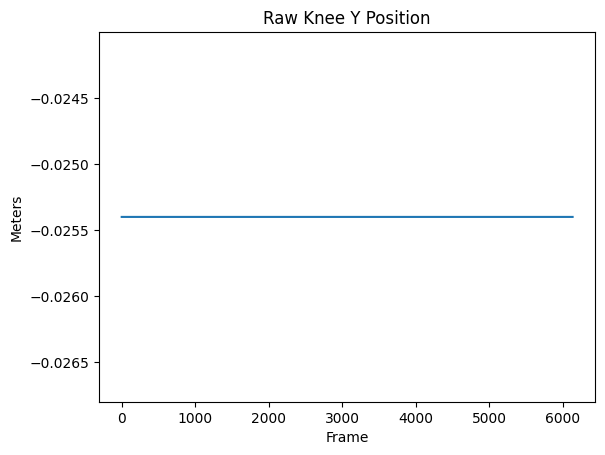

In [29]:
plt.plot(joint_relation[:,1])
plt.title("Raw Knee Y Position")
plt.xlabel("Frame")
plt.ylabel("Meters")
plt.show()


In [40]:
# ----------------------------
# PARAMETERS
# ----------------------------
FPS = 60
DT = 1 / FPS
FRAMES = 300

# rreal extracted joint position (baseline)
BASE_POS = np.array([0.0956, -0.2902, 0.0179])
os.makedirs("data", exist_ok=True)

In [79]:
np.random.seed(42)

frames = 600
t = np.linspace(0, 10, frames)

# Ground-truth motion (single joint, 3D)
x_gt = 0.5 * np.sin(2 * np.pi * 1.0 * t)
y_gt = 0.3 * np.sin(2 * np.pi * 1.5 * t + 0.5)
z_gt = 0.2 * np.sin(2 * np.pi * 0.8 * t + 1.0)

ground_truth = np.vstack([x_gt, y_gt, z_gt]).T

# Add measurement noise
noise = np.random.normal(0, 0.05, ground_truth.shape)
measured = ground_truth + noise

df = pd.DataFrame({
    "x_gt": x_gt, "y_gt": y_gt, "z_gt": z_gt,
    "x_meas": measured[:,0],
    "y_meas": measured[:,1],
    "z_meas": measured[:,2]
})

df.to_csv("synthetic_motion.csv", index=False)
print("Saved synthetic_motion.csv")


Saved synthetic_motion.csv


In [ ]:
df = pd.read_csv("..\data\processed\synthetic_motion.csv")

gt = df[["x_gt", "y_gt", "z_gt"]].values
meas = df[["x_meas", "y_meas", "z_meas"]].values

print("Data shape:", meas.shape)


Data shape: (600, 3)


In [82]:
# Gaussian filter
def gaussian_filter(signal, sigma=2):
    return gaussian_filter1d(signal, sigma=sigma)

# Butterworth low-pass filter
def butterworth_filter(signal, cutoff=2.0, fs=60, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, cutoff / nyq, btype='low')
    return filtfilt(b, a, signal)

# 1D Kalman filter
def kalman_filter(signal, q=1e-5, r=0.002):
    x = 0.0
    p = 1.0
    filtered = []

    for z in signal:
        # Prediction
        p = p + q

        # Update
        k = p / (p + r)
        x = x + k * (z - x)
        p = (1 - k) * p

        filtered.append(x)

    return np.array(filtered)


In [83]:
gaussian = np.zeros_like(meas)
butterworth = np.zeros_like(meas)
kalman = np.zeros_like(meas)

for i in range(3):
    gaussian[:, i] = gaussian_filter(meas[:, i])
    butterworth[:, i] = butterworth_filter(meas[:, i])
    kalman[:, i] = kalman_filter(meas[:, i])



In [84]:
kalman_butter = np.zeros_like(meas)
kalman_gaussian = np.zeros_like(meas)
kalman_butter_gaussian = np.zeros_like(meas)

for i in range(3):
    kalman_butter[:, i] = butterworth_filter(kalman[:, i])
    kalman_gaussian[:, i] = gaussian_filter(kalman[:, i])
    kalman_butter_gaussian[:, i] = gaussian_filter(kalman_butter[:, i])



In [85]:
def rmse(a, b):
    return np.sqrt(np.mean((a - b)**2))

def snr(signal, error):
    return 10 * np.log10(np.var(signal) / np.var(error))


In [86]:
filters = {
    "Gaussian": gaussian,
    "Butterworth": butterworth,
    "Kalman": kalman,
    "Kalman+Butterworth": kalman_butter,
    "Kalman+Gaussian": kalman_gaussian,
    "Kalman+Butterworth+Gaussian": kalman_butter_gaussian
}

results = []

for name, data in filters.items():
    results.append({
        "Filter": name,
        "RMSE": rmse(data, gt),
        "STD": np.std(data),
        "SNR": snr(gt, data - gt)
    })

metrics_df = pd.DataFrame(results)
metrics_df.to_csv("filter_metrics.csv", index=False)
metrics_df



,Filter,RMSE,STD,SNR
0,Gaussian,0.021723,0.244710,21.325839
1,Butterworth,0.019547,0.244859,22.269627
2,Kalman,0.202466,0.140558,1.891753
3,Kalman+Butterworth,0.202715,0.138391,1.881289
4,Kalman+Gaussian,0.202735,0.137412,1.880205
5,Kalman+Butterworth+Gaussian,0.203046,0.135406,1.867096


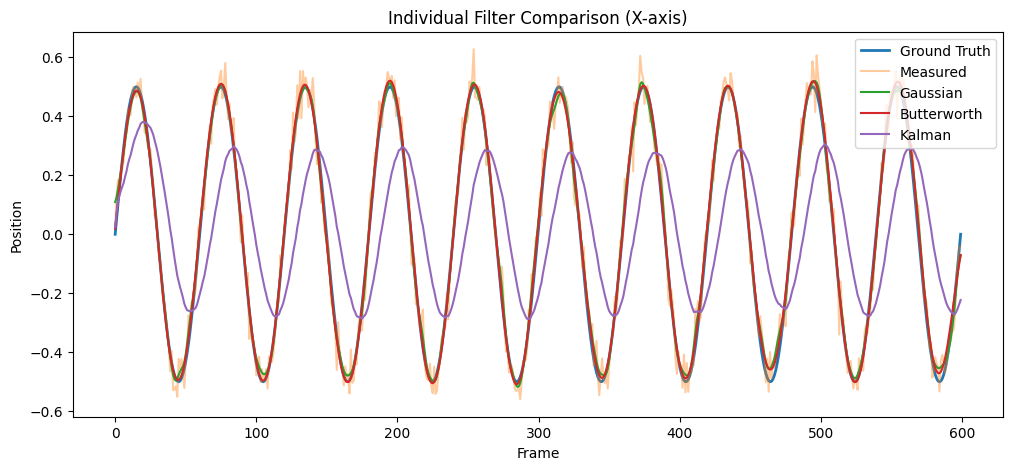

In [87]:
plt.figure(figsize=(12, 5))
plt.plot(gt[:, 0], label="Ground Truth", linewidth=2)
plt.plot(meas[:, 0], label="Measured", alpha=0.4)
plt.plot(gaussian[:, 0], label="Gaussian")
plt.plot(butterworth[:, 0], label="Butterworth")
plt.plot(kalman[:, 0], label="Kalman")
plt.title("Individual Filter Comparison (X-axis)")
plt.xlabel("Frame")
plt.ylabel("Position")
plt.legend()
plt.show()


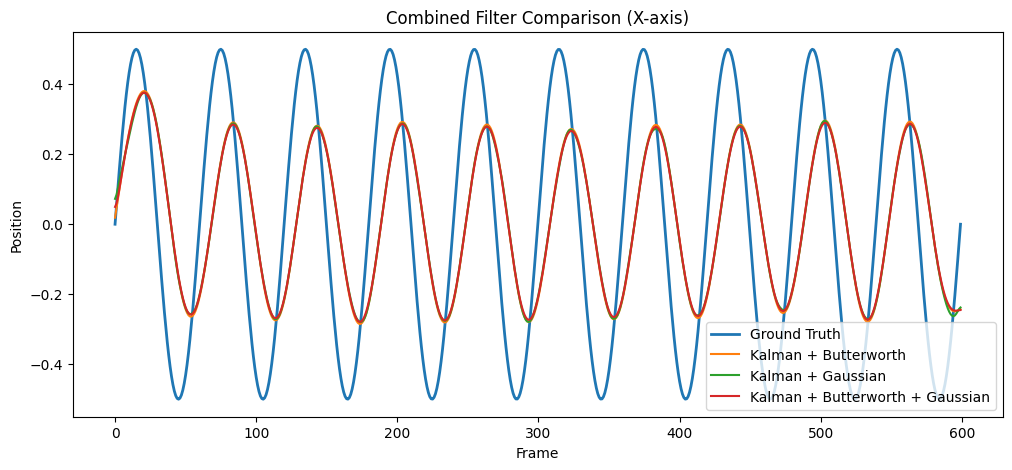

In [88]:
plt.figure(figsize=(12, 5))
plt.plot(gt[:, 0], label="Ground Truth", linewidth=2)
plt.plot(kalman_butter[:, 0], label="Kalman + Butterworth")
plt.plot(kalman_gaussian[:, 0], label="Kalman + Gaussian")
plt.plot(kalman_butter_gaussian[:, 0], label="Kalman + Butterworth + Gaussian")
plt.title("Combined Filter Comparison (X-axis)")
plt.xlabel("Frame")
plt.ylabel("Position")
plt.legend()
plt.show()



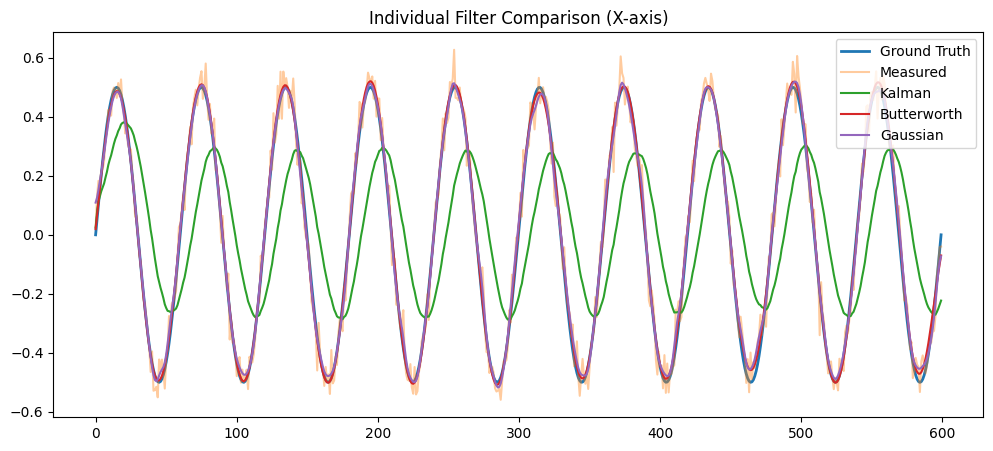

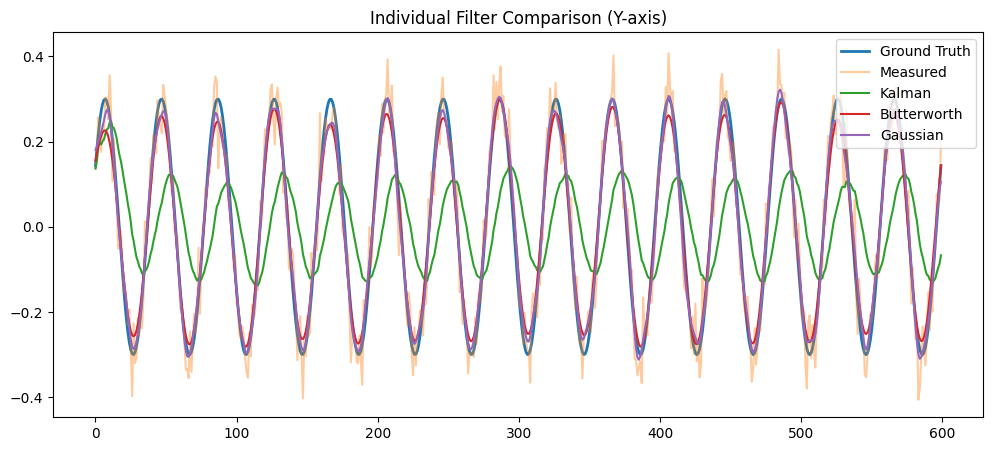

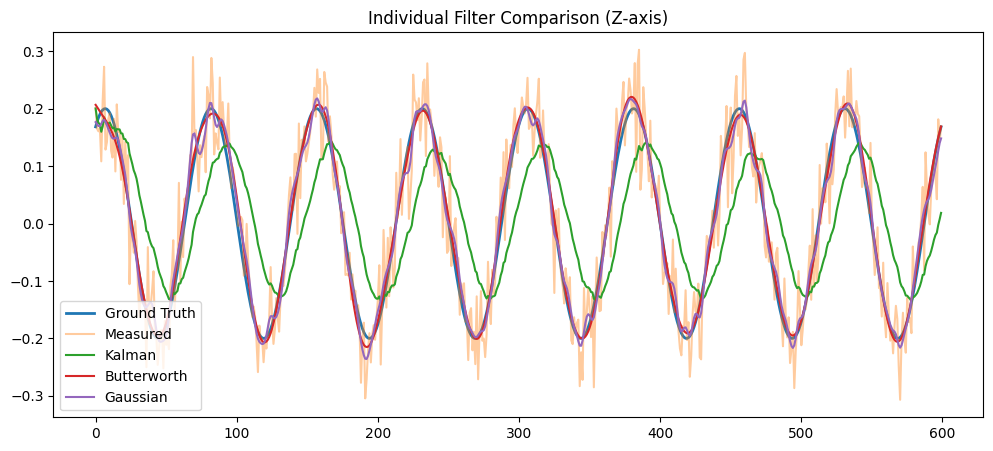

In [89]:
for axis, label in enumerate(["X", "Y", "Z"]):
    plt.figure(figsize=(12,5))
    plt.plot(gt[:, axis], label="Ground Truth", linewidth=2)
    plt.plot(meas[:, axis], label="Measured", alpha=0.4)
    plt.plot(kalman[:, axis], label="Kalman")
    plt.plot(butterworth[:, axis], label="Butterworth")
    plt.plot(gaussian[:, axis], label="Gaussian")
    plt.title(f"Individual Filter Comparison ({label}-axis)")
    plt.legend()
    plt.show()



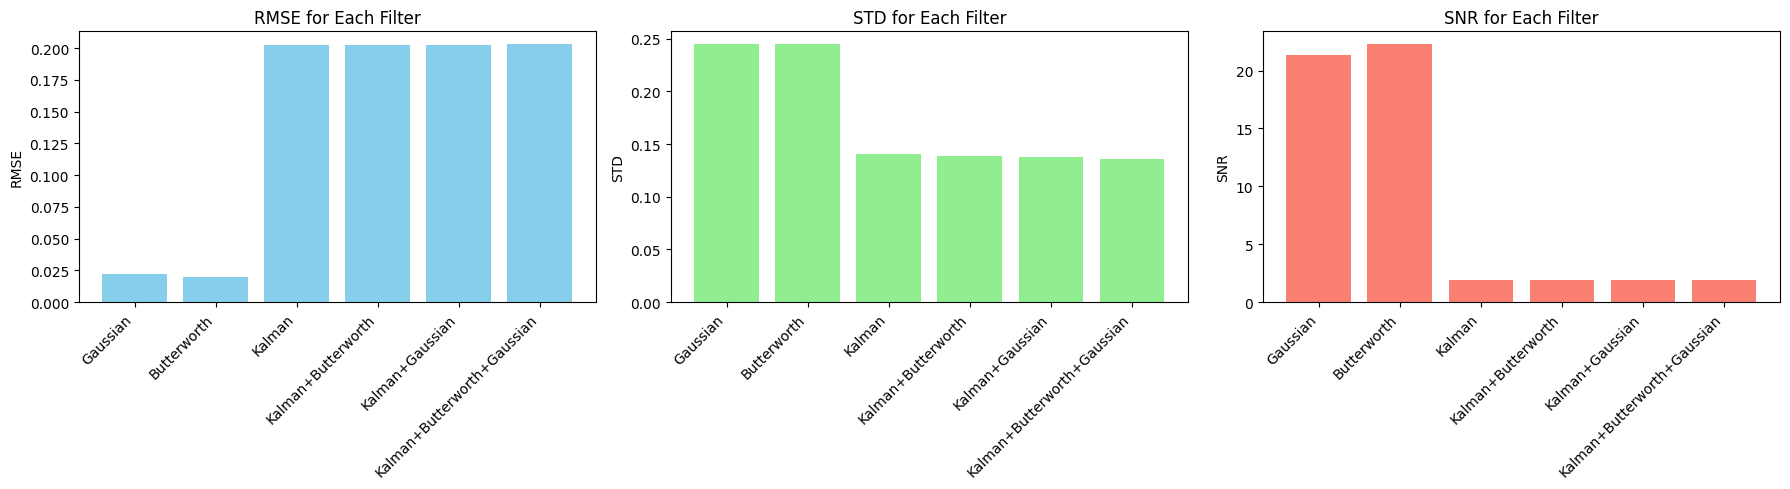

In [90]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics data
filters = ['Gaussian', 'Butterworth', 'Kalman', 
           'Kalman+Butterworth', 'Kalman+Gaussian', 'Kalman+Butterworth+Gaussian']
RMSE = [0.021723, 0.019547, 0.202466, 0.202715, 0.202735, 0.203046]
STD = [0.244710, 0.244859, 0.140558, 0.138391, 0.137412, 0.135406]
SNR = [21.325839, 22.269627, 1.891753, 1.881289, 1.880205, 1.867096]

x = np.arange(len(filters))

fig, axs = plt.subplots(1, 3, figsize=(18,5))

# RMSE plot
axs[0].bar(x, RMSE, color='skyblue')
axs[0].set_xticks(x)
axs[0].set_xticklabels(filters, rotation=45, ha='right')
axs[0].set_ylabel('RMSE')
axs[0].set_title('RMSE for Each Filter')

# STD plot
axs[1].bar(x, STD, color='lightgreen')
axs[1].set_xticks(x)
axs[1].set_xticklabels(filters, rotation=45, ha='right')
axs[1].set_ylabel('STD')
axs[1].set_title('STD for Each Filter')

# SNR plot
axs[2].bar(x, SNR, color='salmon')
axs[2].set_xticks(x)
axs[2].set_xticklabels(filters, rotation=45, ha='right')
axs[2].set_ylabel('SNR')
axs[2].set_title('SNR for Each Filter')

plt.tight_layout()
plt.show()
